## Contenu :
### 1.  ElasticNetCV
### 2.  Polynomial Features & Linear Regression
### 3.  Random Forest Regression
### 4.  Tableau des résultats

Ces algorithmes ont été essayés avec de nombreuses combinaisons de données et de variables, comme détaillé dans le rapport. Ce notebook contient le code uniquement pour le modèle finalement retenu  pour chaque algorithme. (Le code de toutes les combinaisons testées se trouve dans le branch "Deborah" du repo Github)
______________________________________________________________________________________

## 1. ElasticNetCV

Les meilleurs résultats pour cet algorithme ont été obtenus lorsque les données de la production éolienne quotidienne de la région Hauts de France (région la plus productive) du 2016 au 2019 ont été utilisées, avec les variables explicatives suivantes: année, mois, jour de la semaine, vitesse du vent moyenne quotidienne, temperature moyenne quotidienne 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.feature_selection import f_regression
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV

In [2]:
#import des données (préparée dans le notebook "Visualisation")
df = pd.read_csv("tempdata_2016_2019.csv")
# on prend la région Hauts de France
HDF = df.loc[(df["Région"] == "Hauts-de-France")]
HDF.shape
# 1,461 observations

(1461, 13)

In [3]:
HDF.isna().sum()
# il n'y a pas de valeurs manquantes dans la colonne "Eolien"

Région                            0
Annee                             0
Month                             0
Date                              0
Day                               0
Eolien_sum(MW)                    0
Vitesse_vent_mean(m/s)            0
Solaire_sum(MW)                   0
Rayonnement_solaire_mean(W/m2)    0
Consommation-sum(MW)              0
TMin (°C)                         0
TMax (°C)                         0
TMoy (°C)                         0
dtype: int64

In [4]:
# Separer les variables catégorielles avant de normaliser les variables numeriques
Categories = HDF[['Annee','Month', 'Day']]

# supprimer ces colonnes et les colonnes que nous n'allons pas utiliser
Data = HDF.drop(['Annee', 'Month', 'Day', 'Région', 'Date','Consommation-sum(MW)',
                 'Solaire_sum(MW)','Rayonnement_solaire_mean(W/m2)','TMin (°C)','TMax (°C)'], axis=1)

# standardisation des colonnes quantitatives
scaler = preprocessing.StandardScaler().fit(Data)
Data[Data.columns] = pd.DataFrame(scaler.transform(Data), index=Data.index)

# standardisation des colonnes quantitatives
scaler = preprocessing.StandardScaler().fit(Data)
Data[Data.columns] = pd.DataFrame(scaler.transform(Data), index=Data.index)

# remettre les variables categorielles et les dichotomiser
Data = Data.join(Categories)
Data = pd.get_dummies(data=Data, columns=['Annee', 'Month', 'Day'])

# Separer target & variables explicatives et separer train & test
data = Data.drop('Eolien_sum(MW)', axis=1)
target = Data['Eolien_sum(MW)']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

# Application du model : ElasticNetCV
model_en = ElasticNetCV(cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0))
model_en.fit(X_train, y_train)

ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99))

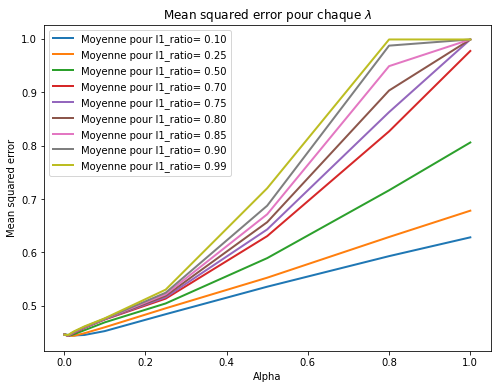

In [5]:
# Afficher "Mean squared error" v "alpha" pour chaque lambda
alphas = model_en.alphas_
plt.figure(figsize=(8, 6))
for i in range(model_en.mse_path_.shape[0]) :
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1),
             label='Moyenne pour l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend()
plt.savefig("Pictures/#24_-_ElasticNet_alphas.png", dpi=150, bbox_inches='tight')
plt.show();

In [6]:
# Afficher les RMSE & scores
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)
print('rmse train :', np.sqrt(mean_squared_error(y_train, pred_train)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test)))

print('score train :', model_en.score(X_train, y_train))
print('score test :', model_en.score(X_test, y_test))

rmse train : 0.6591605762499915
rmse test : 0.6853462121753503
score train : 0.5642789975745981
score test : 0.5352877740712408


## Polynomial Features & Linear Regression

Les meilleurs résultats pour cet algorithme ont été obtenus lorsque les données de la production éolienne quotidienne des quatre régions les plus productives du 2016 au 2019 ont été utilisées, avec les variables explicatives suivantes: région, année, mois, jour de la semaine, vitesse du vent moyenne quotidienne, temperature moyenne quotidienne. 

In [12]:
Regions = df.loc[(df["Région"] == "Hauts-de-France") | (df["Région"] == "Grand Est") 
             | (df["Région"] == "Occitanie") | (df["Région"] == "Centre-Val de Loire")]
# supprimer les colonnes que nous n'allons pas utiliser
Regions = Regions.drop(['Date','Solaire_sum(MW)','Rayonnement_solaire_mean(W/m2)','Consommation-sum(MW)',
                  'TMin (°C)','TMax (°C)'], axis=1)

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn import set_config
set_config(display='diagram')

categorical_features = ['Annee','Month', 'Day', 'Région']
numeric_features = ['Vitesse_vent_mean(m/s)','TMoy (°C)']
degree=5
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = Pipeline(
                    steps=[ ('poly', PolynomialFeatures(degree)),
                            ('scaler', preprocessing.StandardScaler()) ])
preprocessor = ColumnTransformer(
                transformers=[ ('num', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)])
# Création de Pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])
X = Regions.drop('Eolien_sum(MW)', axis = 1)
y = Regions['Eolien_sum(MW)']
X_train, X_test, y_train, y_test = train_test_split( X, y , test_size = 0.2 , random_state = 42 )
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=5)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Vitesse_vent_mean(m/s)',
                                                   'TMoy (°C)']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Annee', 'Month', 'Day',
                                                   'Région'])])),
                ('classifier', LinearRegression())])

In [15]:
print('score train :', model.score(X_train, y_train))
print('score test :', model.score(X_test, y_test))
pred = model.predict(X_train)
pred_test = model.predict(X_test)
print('rmse train :', np.sqrt(mean_squared_error(y_train, pred)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test)))

score train : 0.5350281177740879
score test : 0.5002888767419338
rmse train : 2940.563001726181
rmse test : 3023.634011264035


## Random Forest Regression

Les meilleurs résultats pour cet algorithme ont été obtenus lorsque les données de la production éolienne quotidienne des quatre régions les plus productives du 2016 au 2019 ont été utilisées (comme pour l'algorithme PolynomialFeature & Linear Regression), avec les variables explicatives suivantes: région, année, mois, jour de la semaine, vitesse du vent moyenne quotidienne, temperature moyenne quotidienne. 

In [17]:
Regions.head(3)

,Région,Annee,Month,Day,Eolien_sum(MW),Vitesse_vent_mean(m/s),TMoy (°C)
4383,Centre-Val de Loire,2016,1,Friday,1994.0,9.20000,6.12
4384,Centre-Val de Loire,2016,1,Saturday,4833.0,9.75375,9.07
4385,Centre-Val de Loire,2016,1,Sunday,4298.0,10.45125,6.52


In [20]:
# Preparation des données :
Categories = Regions[['Annee','Month', 'Day', 'Région']]
Data = Regions.drop(['Annee','Month','Day','Région'], axis=1)

scaler = preprocessing.StandardScaler().fit(Data)
Data[Data.columns] = pd.DataFrame(scaler.transform(Data), index=Data.index)

Data = Data.join(Categories)
Data = pd.get_dummies(data=Data, columns=['Annee', 'Month', 'Day','Région'])

# Separer target & variables explicatives et séparer train & test
data = Data.drop('Eolien_sum(MW)', axis=1)
target = Data['Eolien_sum(MW)']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

# création de RandomForestRegressor, utilisant les parametres trouvés précedemment par GridSearchCV
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=8, max_features='auto', n_estimators=50,random_state=100)
model.fit(X_train, y_train) 

# prédiction sur train set & calculation RMSE et R2 score
from sklearn.metrics import r2_score
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))
print(r2_score(y_train, pred_train))

# prédiction sur test set & calculation RMSE et R2 score
pred_test = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test)))
print(r2_score(y_test, pred_test))

0.4997651383320855
0.752174046960276
0.6011403505414908
0.626932407099339


In [21]:
# afficher les predictions
moy = scaler.mean_[0]
ec = scaler.scale_[0]
print("moyenne :", moy)
print("ecart-type :", ec)

predictions = pd.DataFrame({'true': (y_test*ec)+moy, 'predicted': np.round((pred_test*ec)+moy)}, 
             index=X_test.index)
predictions.head(10)

moyenne : 4134.652977412731
ecart-type : 4305.425222004455


,true,predicted
7273,6805.0,9465.0
12283,1880.0,1888.0
11848,1831.0,2584.0
11947,2528.0,3422.0
4825,5242.0,2634.0
4980,116.0,1015.0
6671,7797.0,5883.0
4789,1146.0,1411.0
4935,1189.0,1260.0
12450,2882.0,3190.0


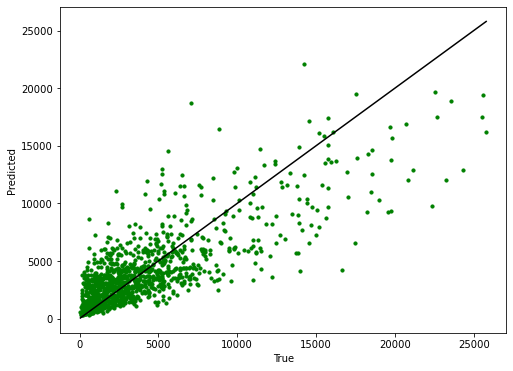

In [22]:
# afficher un nuage de points 
plt.figure(figsize=(8, 6))
plt.scatter(predictions.true, predictions.predicted,color='green', s=10)
plt.plot((predictions.true.min(), predictions.true.max()), (predictions.true.min(), predictions.true.max()),color='k')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.savefig("Pictures/#27_-_RandomForestRegressor_predictions.png", dpi=150, bbox_inches='tight')
plt.show();

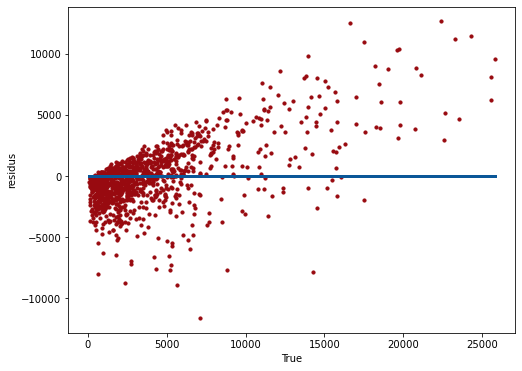

In [23]:
# afficher la distribution des résidus

residus = predictions.true - predictions.predicted
plt.figure(figsize=(8, 6))
plt.scatter(predictions.true, residus, color='#980a10', s=10)
plt.plot((predictions.true.min(), predictions.true.max()), (0, 0), lw=3, color='#0a5798')
plt.xlabel('True')
plt.ylabel('residus')
plt.savefig("Pictures/#28_-_RandomForestRegressor_residus.png", dpi=150, bbox_inches='tight')
plt.show();
# la distribution des residus n'est pas de toute aléatoire
# Pour les valeurs de production éolienne quotidienne > ~13000, les predictions sont trop basses
# Pour les valeurs < ~4000, les predictions sont trop élévées

## Tableau des résultats

In [24]:
LinearRegression_results = pd.read_csv("Wind_LR_results.csv")
LinearRegression_results

,data,model,données,train score,test score,train RMSE,test RMSE
0,HDF/2019(univarié),Linear Regression,2919,0.39,0.39,0.77,0.83
1,HDF/2019(multivarié),ElasticNetCV,2919,0.40,0.36,0.76,0.82
2,HDF/2016-2019,ElasticNetCV,11723,0.40,0.40,0.77,0.81
3,Regions/2016-2019,ElasticNetCV,46892,0.41,0.40,0.77,0.76
4,Regions/2016-2019+conso,ElasticNetCV,46892,0.41,0.40,0.77,0.76
5,HDF/DailyProd/2016-2019,ElasticNetCV,1461,0.56,0.54,0.66,0.68
6,HDF/DailyProd/2016-2019+temp,ElasticNetCV,1461,0.56,0.54,0.66,0.69
7,Régions/DailyProd/2016-2019+temp,ElasticNetCV,5844,0.52,0.50,0.69,0.70
8,sansvaleursextrêmes,ElasticNetCV,5812,0.50,0.51,0.70,0.70


In [25]:
PolynomialFeatures_LinearRegression_results = pd.read_csv("Wind_PF_results.csv")
PolynomialFeatures_LinearRegression_results

,data,model,données,train score,test score,train RMSE,test RMSE
0,HDF/2019(univarié),PolynomialFeatures,2919,0.40,0.36,723,782
1,HDF/2019(multivarié),PolynomialFeatures,2919,0.40,0.38,729,724
2,HDF/2016-2019,PolynomialFeatures,11723,0.43,0.42,576,558
3,Regions/2016-2019,PolynomialFeatures,46892,0.41,0.41,461,454
4,Regions/2016-2019/LassoCV,PolynomialFeatures,46892,0.41,0.40,461,454
5,HDF/DailyProd/2016-2019,PolynomialFeatures,1461,0.58,0.52,3460,3880
6,HDF/DailyProd/2016-2019+temp,PolynomialFeatures,1461,0.57,0.53,3478,3831
7,Régions/DailyProd/2016-2019+temp,PolynomialFeatures,5844,0.54,0.50,3831,3023


In [26]:
RandomForestRegression_results = pd.read_csv("Wind_RFR_results.csv")
RandomForestRegression_results

,data,model,données,train score,test score,train RMSE,test RMSE
0,HDF/DailyProd/2016-2019,RandomForest Regression,1461,0.82,0.54,0.42,0.54
1,HDF/DailyProd/2016-2019+temp,RandomForest Regression,1461,0.84,0.54,0.41,0.68
2,Régions/DailyProd/2016-2019+temp,RandomForest Regression,5844,0.75,0.63,0.50,0.60
3,sansvaleursextrêmes,RandomForest Regression,5812,0.74,0.62,0.51,0.62
